In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [2]:
df = pd.read_csv("aqi_data.csv")

df.head()


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [3]:
# Convert date
df["Date"] = pd.to_datetime(df["Date"])

# Sort by city & date
df = df.sort_values(["City", "Date"])

# Drop classification column
df = df.drop(columns=["AQI_Bucket"])

# Fill missing values (future-proof)
df = df.ffill().bfill()

# Drop rows where AQI is still missing
df = df.dropna(subset=["AQI"])

df.head()


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
0,Ahmedabad,2015-01-01,73.24,141.54,0.92,18.22,17.15,26.64,0.92,27.64,133.36,0.00,0.02,0.00,209.0
1,Ahmedabad,2015-01-02,73.24,141.54,0.97,15.69,16.46,26.64,0.97,24.55,34.06,3.68,5.50,3.77,209.0
2,Ahmedabad,2015-01-03,73.24,141.54,17.40,19.30,29.70,26.64,17.40,29.07,30.70,6.80,16.40,2.25,209.0
3,Ahmedabad,2015-01-04,73.24,141.54,1.70,18.48,17.97,26.64,1.70,18.59,36.08,4.43,10.14,1.00,209.0
4,Ahmedabad,2015-01-05,73.24,141.54,22.10,21.42,37.76,26.64,22.10,39.33,39.31,7.01,18.89,2.78,209.0


In [4]:
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(time_steps, len(X)):
        Xs.append(X[i-time_steps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)


In [5]:
def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model


In [6]:
cities = df["City"].unique()[:5]   # you can increase later
TIME_STEPS = 30

city_results = {}


In [13]:
for city in cities:
    print(f"Training AQI model for: {city}")
    
    city_df = df[df["City"] == city]
    
    X = city_df.drop(columns=["City", "Date", "AQI"]).values
    y = city_df["AQI"].values.reshape(-1, 1)

    X_scaler = MinMaxScaler()
    X_scaled = X_scaler.fit_transform(X)

    y_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(y)

    X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)

    split = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    model = build_lstm((TIME_STEPS, X_seq.shape[2]))

    model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=0
    )

    preds_scaled = model.predict(X_test)
    preds = y_scaler.inverse_transform(preds_scaled)
    y_test_actual = y_scaler.inverse_transform(y_test)

    city_results[city] = {
        "RMSE": np.sqrt(mean_squared_error(y_test_actual, preds)),
        "actual": y_test_actual.flatten(),
        "predicted": preds.flatten()
    }


Training AQI model for: Ahmedabad


C:\Users\dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step  
Training AQI model for: Aizawl


C:\Users\dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step
Training AQI model for: Amaravati


C:\Users\dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step
Training AQI model for: Amritsar


C:\Users\dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step
Training AQI model for: Bengaluru


C:\Users\dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step


In [14]:
rmse_df = pd.DataFrame({
    "City": city_results.keys(),
    "RMSE": [v["RMSE"] for v in city_results.values()]
})

rmse_df


,City,RMSE
0,Ahmedabad,197.037104
1,Aizawl,5.520415
2,Amaravati,23.402551
3,Amritsar,58.647251
4,Bengaluru,18.215041


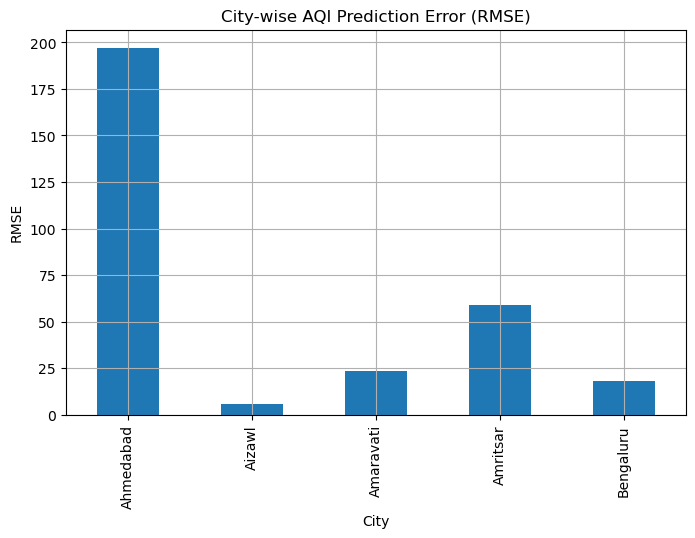

In [18]:
rmse_df.plot(
    x="City",
    y="RMSE",
    kind="bar",
    figsize=(8,5),
    legend=False,
    title="City-wise AQI Prediction Error (RMSE)"
)
plt.ylabel("RMSE")
plt.grid()
plt.show()


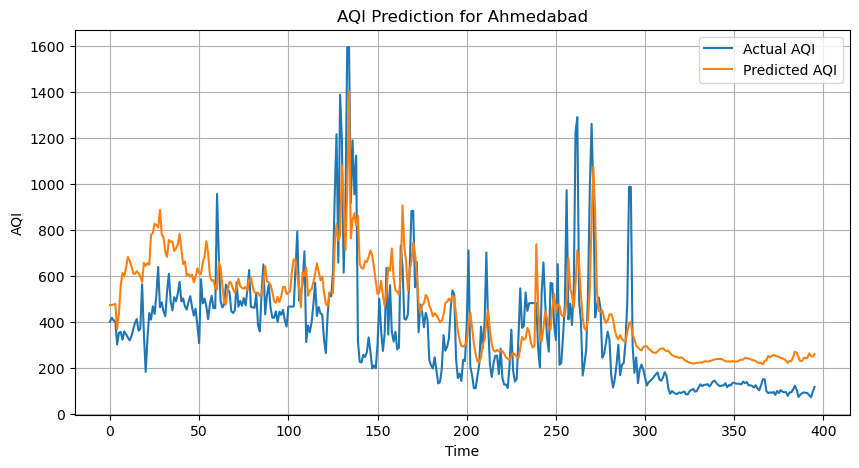

In [16]:
city = cities[0]  # change city index if needed

plt.figure(figsize=(10,5))
plt.plot(city_results[city]["actual"], label="Actual AQI")
plt.plot(city_results[city]["predicted"], label="Predicted AQI")
plt.title(f"AQI Prediction for {city}")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.legend()
plt.grid()
plt.show()


In [27]:
#next dat AQI prediction 
city = "Ahmedabad"

city_df = df[df["City"] == city].copy()
city_df["Date"] = pd.to_datetime(city_df["Date"])
city_df = city_df.sort_values("Date")


In [28]:
features = [
    "PM2.5", "PM10", "NO", "NO2", "NOx",
    "NH3", "CO", "SO2", "O3",
    "Benzene", "Toluene", "Xylene"
]

target = "AQI"

data = city_df[features + [target]].values


In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


In [30]:
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :-1])  # past 30 days features
        y.append(data[i+window_size, -1])     # next day AQI
    return np.array(X), np.array(y)

WINDOW_SIZE = 30
X, y = create_sequences(data_scaled, WINDOW_SIZE)


In [31]:
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

lstm = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

lstm.compile(optimizer="adam", loss="mse")
lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


C:\Users\dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 0.0135
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0095  
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0086
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0079
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0074
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0070 
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0067 
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0064  
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0070  
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0063 
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0061 
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0061  
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0063 
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0060 
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - lo

In [35]:
from tensorflow.keras.layers import GRU

gru = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

gru.compile(optimizer="adam", loss="mse")
gru.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


C:\Users\dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0109
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0075
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0067
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0066 
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0062  
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0062  
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0062  
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0061  
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0062  
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0061 
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0061 
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0060 
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0060  
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0059
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - l

In [36]:
from tensorflow.keras.layers import SimpleRNN

rnn = Sequential([
    SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

rnn.compile(optimizer="adam", loss="mse")
rnn.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


C:\Users\dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0164
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0088  
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0072  
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0072  
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0069  
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0064
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0067  
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0063  
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0060  
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0058 
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0058
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0060  
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0057  
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0060 
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

In [37]:
def inverse_aqi(y_scaled):
    dummy = np.zeros((len(y_scaled), data.shape[1]))
    dummy[:, -1] = y_scaled.flatten()
    return scaler.inverse_transform(dummy)[:, -1]

y_test_actual = inverse_aqi(y_test)

y_pred_lstm = inverse_aqi(lstm.predict(X_test))
y_pred_gru  = inverse_aqi(gru.predict(X_test))
y_pred_rnn  = inverse_aqi(rnn.predict(X_test))



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step 


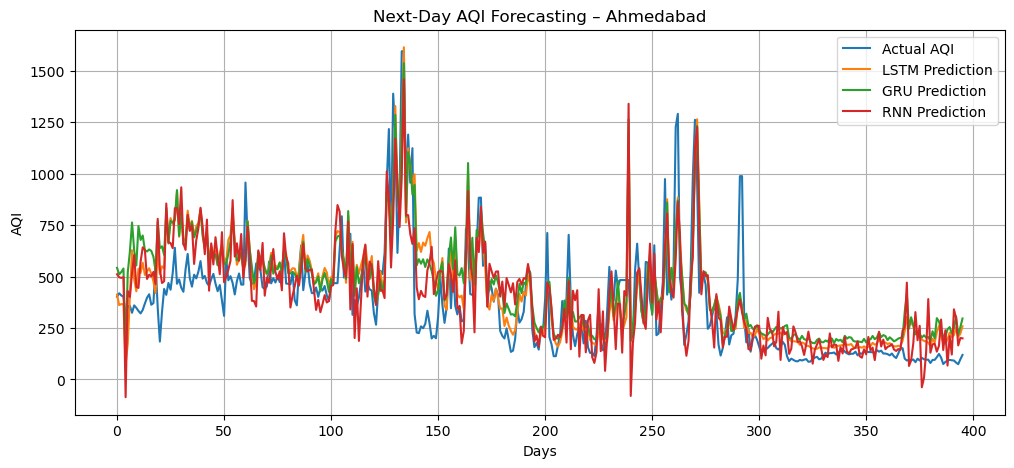

In [38]:
plt.figure(figsize=(12,5))
plt.plot(y_test_actual, label="Actual AQI")
plt.plot(y_pred_lstm, label="LSTM Prediction")
plt.plot(y_pred_gru, label="GRU Prediction")
plt.plot(y_pred_rnn, label="RNN Prediction")
plt.title(f"Next-Day AQI Forecasting – {city}")
plt.xlabel("Days")
plt.ylabel("AQI")
plt.legend()
plt.grid()
plt.show()


In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2


In [40]:
results = pd.DataFrame({
    "Model": ["RNN", "LSTM", "GRU"],
    "RMSE": [
        metrics(y_test_actual, y_pred_rnn)[0],
        metrics(y_test_actual, y_pred_lstm)[0],
        metrics(y_test_actual, y_pred_gru)[0]
    ],
    "MAE": [
        metrics(y_test_actual, y_pred_rnn)[1],
        metrics(y_test_actual, y_pred_lstm)[1],
        metrics(y_test_actual, y_pred_gru)[1]
    ],
    "R²": [
        metrics(y_test_actual, y_pred_rnn)[2],
        metrics(y_test_actual, y_pred_lstm)[2],
        metrics(y_test_actual, y_pred_gru)[2]
    ]
})

results


,Model,RMSE,MAE,R²
0,RNN,182.009039,134.133252,0.475109
1,LSTM,170.515231,124.126527,0.539309
2,GRU,178.136208,136.796110,0.497209


In [41]:
###########streamlit
import joblib

lstm.save("lstm_aqi_model.keras")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']